# Lab-05: Visualizing tweets from the 2020 US presidential election

In [2]:
import os
import pandas as pd

# Dataset is a randomly sampled subset of: https://www.kaggle.com/manchunhui/us-election-2020-tweets
trump = pd.read_csv("2020_tweets_trump.csv", lineterminator='\n')
biden = pd.read_csv("2020_tweets_biden.csv", lineterminator='\n')

In [3]:
len(biden), len(trump)

(100000, 100000)

In [4]:
M = 10000
trump = trump.sample(n=M//2)
biden = biden.sample(n=M//2)

In [6]:
biden_tweets = biden['tweet'].tolist()
trump_tweets = trump['tweet'].tolist()

In [7]:
len(biden), len(trump)

(5000, 5000)

# Preprocessing pipeline

In [8]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    # http://emailregex.com/
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

In [9]:
from tqdm import tqdm

with tqdm(total=M//2) as bar:
    for i, (bt, tt) in enumerate(zip(biden_tweets, trump_tweets)):
        biden_tweets[i] = pipeline(bt)
        trump_tweets[i] = pipeline(tt)
        bar.update()

100%|██████████| 5000/5000 [00:55<00:00, 89.53it/s]


In [ ]:
#biden_tweets

### Concatenate documents for vocab generation

In [10]:
all_tweets = biden_tweets + trump_tweets

## (20 pts) Task I: Train a Doc2Vec model (using the Gensim package) on tweets from the 2020 US presidential election

*Docs*: 

* https://radimrehurek.com/gensim/models/doc2vec.html

*Useful tutorials*: 

* https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

### Hyperparameters

In [11]:
# Change as needed
K = 20
word_frequency_threshold = 3
epochs = 10
lr = 0.01

In [12]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(vector_size=K, min_count=word_frequency_threshold, epochs=epochs)

In [13]:
# Your code goes here
import random
print(len(biden_tweets),len(trump_tweets))
all_tweets = biden_tweets + trump_tweets
#random.shuffle(all_tweets)
train_corpus =  all_tweets
print(len(all_tweets))

5000 5000
10000


In [14]:
import gensim
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(corpus = train_corpus))
#test_corpus = list(read_corpus(corpus = test_corpus, tokens_only=True))
model.build_vocab(train_corpus)

In [15]:
model.train(train_corpus, total_examples=10000, epochs=epochs)

In [16]:
#print(test_corpus[1])
model.random.seed(0)
#print(train_corpus[1])
vector = model.infer_vector(train_corpus[1][0])
print(vector)

[ 0.02944336  0.03578372  0.01754394  0.0107742   0.03329484  0.00330899
 -0.00750366  0.019094   -0.01297931 -0.00919189  0.01010351 -0.01264044
 -0.00188304 -0.00083168 -0.01812486  0.02826492 -0.03625841  0.00250961
  0.02838124  0.02787584]


## (10  pts) Task II: Evaluate your model by computing the most similar documents (tweets) to new (perhaps made up) tweets

In [17]:
# Template function
def find_similar_tweets(tweet, top_n=10):
    model.random.seed(0)
    doc_vector = model.infer_vector(tweet)
    sims = model.docvecs.most_similar([doc_vector], topn=top_n)
    return sims

In [18]:
# notice all_tweets = biden_tweets(5000) + trump_tweets(5000)
model.random.seed(1)
a = find_similar_tweets(['make', 'american', 'great', 'again'])  # Turmp's, similar should greater than 5000
print(a)
print(train_corpus[8048])
print(train_corpus[6693])

[(235, 0.8515793085098267), (9497, 0.8454534411430359), (310, 0.8450128436088562), (8614, 0.8383842706680298), (2804, 0.8234621286392212), (9216, 0.8221381306648254), (818, 0.8199077248573303), (7022, 0.8193467855453491), (1314, 0.8173482418060303), (2725, 0.8167170286178589)]
TaggedDocument(['cmo', 'debates', 'trump', 'biden'], [8048])
TaggedDocument(['pauley', 'teeks', 'trump', 'vote', 'trump', 'out', 'vote', 'election', 'day', 'elections'], [6693])


In [19]:
print(train_corpus[0][0])

['joe', 'biden', 'les', 'hqfej']


## (10 pts extra credit) Task III: Produce a scatter plot of the compressed document embeddings (2D or 3D)

*Useful resources*:

* http://projector.tensorflow.org/

In [ ]:
# Your code goes here

In [20]:
model.infer_vector(train_corpus[1][0])

array([ 0.02517677,  0.06009842,  0.04507628,  0.04426096,  0.01111774,
        0.04572444,  0.03443473,  0.03147816,  0.01956256, -0.0297564 ,
       -0.01865597, -0.05472972, -0.00991499,  0.00368632, -0.02789892,
        0.01184937, -0.04712884,  0.03291693,  0.00192338,  0.01786315],
      dtype=float32)

In [21]:
for i in train_corpus[0:8]:
    print(i)

TaggedDocument(['joe', 'biden', 'les', 'hqfej'], [0])
TaggedDocument(['just', 'joe', 'biden', 'say', 'donald', 'trump', 'ux'], [1])
TaggedDocument(['if', 'trump', 'wisconsin', 'biden', 'america', 'decides', 'vote', 'nh', 'od', 'ebcb'], [2])
TaggedDocument(['apparently', 'wow', 'biden', 'were', 'zqpr', 'em', 'ymi'], [3])
TaggedDocument(['if', 'trump', 'ao', 'bill', 'clintons', 'trump', 'biden'], [4])
TaggedDocument(['eee', 'trumptr', 'usa', 'elections', 'trump', 'biden', 'bliq', 'nh'], [5])
TaggedDocument(['team', 'trump', 'donald', 'trump', 'these', 'us', 'elections', 'biden', 'harris', 'united', 'states', 'america', 'community'], [6])
TaggedDocument(['tweet', 'donald', 'trump', 'twitter', 'la', 'biden', 'trump', 'jd'], [7])


In [25]:
model.random.seed(10)
t = 0
b = 0

author = []
X = []
for i in train_corpus[3000:7000]: # draw part of courps
    model.random.seed(0)
    vec = model.infer_vector(i[0]).tolist()
    if i[1][0] < 5000:
        X.append(vec)
        b += 1
        author.append("biden")        
    elif i[1][0] >= 5000:
        X.append(vec)
        t += 1
        author.append("Biden")

print(t,b)
print(len(X))

2000 2000
4000


/home/qsfang.lion/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

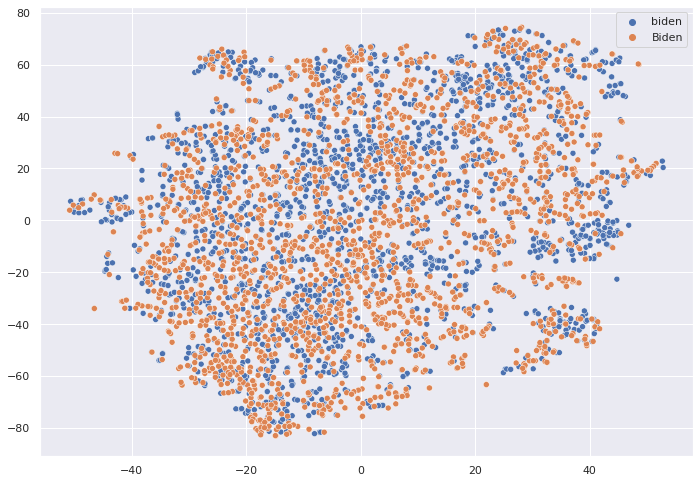

In [26]:
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette( )
#X = model[model.wv.vocab]
#print(X)
X_tsne = TSNE(n_components=2).fit_transform(X)#n_components=2，

sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=author,  legend='full')
#print(X_tsne[0:5])
#print(author[0:5])